# Distributed Training with PyTorch

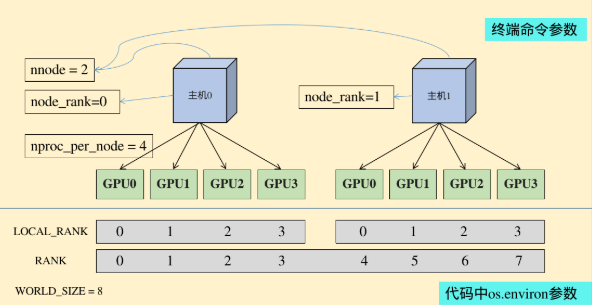


## 多卡并行训练

并行训练希望同时使用多张GPU对同一个模型进行训练，**torch.distributed** 提供了一系列的进程通信功能包括发送，接受，reduce，gather等功能，同时 **torch.nn.parallel.DistributedDataParallel** 将训练过程中对权重梯度的同步过程优化并封装起来，提供了一种简单的，无需使用者关注底层实现的并行训练方式，同时 **torch.utils.data.distributed.DistributedSampler** 完成数据在不同进程的划分，相当于极大的扩充了 **batch size** （如果没有 BN 或者使用 同步BN时）。

## 进程组的初始化

想要多个进程之间进行通讯，首先要进行进程组的初始化，这样通过使用 rank 就可以标注组内的每一个进程，从而可以通过 rank 来指定哪些进程需要通信。初始化方法 **torch.distributed.init** 函数：

```python
def init_process_group(
    backend: Optional[str] = None,
    init_method: Optional[str] = None,
    timeout: Optional[timedelta] = None,
    world_size: int = -1,
    rank: int = -1,
    store: Optional[Store] = None,
    group_name: str = "",
    pg_options: Optional[Any] = None,
    device_id: Optional[torch.device] = None,
)

```

args:
- *backend* 用于指定不同进程通信的后端，下图是**torch**支持的内置的后端，以及对应的可支持的通信的功能：

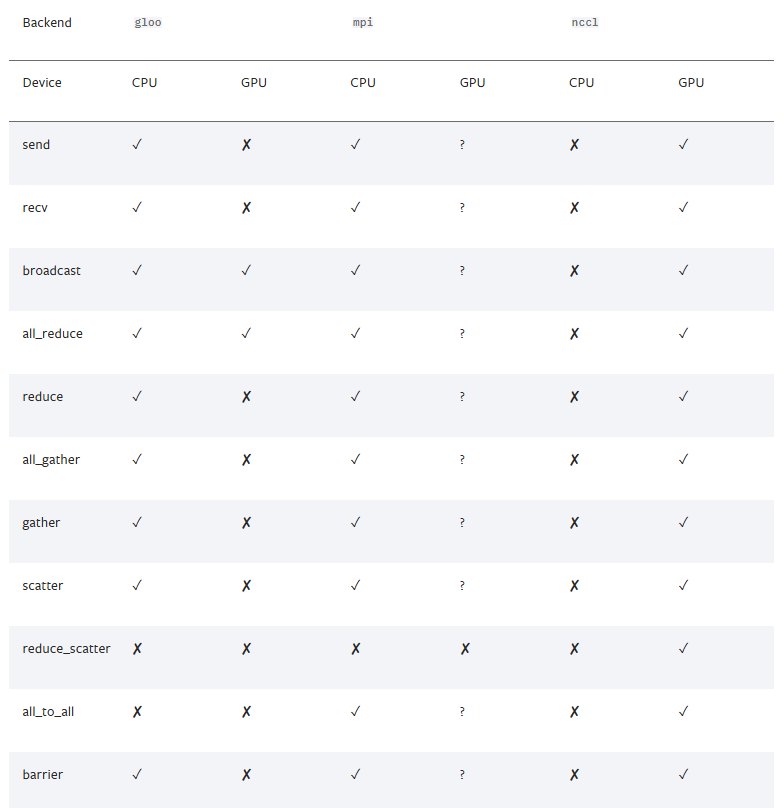

- *init_method* 指定初始化方式，即如何让进程互相找到对方。

    有三种初始化方式：
    
    1. TCP 初始化：需要指定一个所有进程都能访问的地址，一般指定0号进程所在主机地址。该方法需要指定本进程的 rank 和 world_size，例子如下：
    ```python
    import torch.distributed as dist
    # Use address of one of the machines
    dist.init_process_group(backend, init_method='tcp://10.1.1.20:23456', rank=args.rank, world_size=4)
    ```
    
    2. 共享文件系统初始化：需要在共享文件系统中指定一个不存在的文件作为介质，同时也需要指定 rank 和 world_size:
    ```python
    import torch.distributed as dist
    # rank should always be specified
    dist.init_process_group(backend, init_method='file:///mnt/nfs/sharedfile', world_size=4, rank=args.rank)
    ```
    
    3. 使用环境变量初始化：在使用 **torch.distributed.launch** 或者 **torchrun** 启动一堆进程时，会自动为每个进程设定一些特殊环境变量（后面详细介绍，这里只放相关的 4 个）：
    - MASTER_ADDR : 0 号进程所在节点的 IP 地址，在启动脚本中使用 --master_addr=xx.xx.xx.xx 指定之后会传递给每一个进程
    - MASTER_PORT : 0 号进程所在节点空闲端口号，在启动脚本中使用 --master_port=xxxx 指定之后会传递给每一个进程
    - WORLD_SIZE : --nnodes=NNODES, --nproc_per_node=NPPN，可计算出 WORLD_SIZE，自动传递给所有进程，既可以在调用参数中指定，也可以用环境变量指定
    - RANK : 每个进程的全局 RANK，启动时会自动分配。
    
      例子(使用 "env://" 或者 默认值）：
    ```python
    import torch.distributed as dist
    # rank should always be specified
    dist.init_process_group(backend, init_method='env://')
    ```
在进程退出之前调用 ***destroy_process_group()*** 来释放进程组资源。

## 进程间通信
在进程组初始化完成之后，就可以使用一些进程间通信的功能。
例如：
- Distributed Key-Value Store ：用于传递键值对，具体用法参考官网。
- Point-to-point communication ：p2p通信传递信息，例如：
```python
torch.distributed.send(tensor, dst, group=None, tag=0)
torch.distributed.recv(tensor, src=None, group=None, tag=0)
torch.distributed.isend(tensor, dst, group=None, tag=0)
torch.distributed.irecv(tensor, src=None, group=None, tag=0)
# for more functions, please refer to https://pytorch.org/docs/stable/distributed.html
```
- Collective functions ：包括广播，收集，reduce等分布式数据操作
```python
torch.distributed.broadcast(tensor, src, group=None, async_op=False)  # 将进程 rank = src 的 tensor 广播到整个进程组，注意每个进程的 tensor 的形状必须一致。如果 async_op == True，则该操作为异步操作。
torch.distributed.all_reduce(tensor, op=<RedOpType.SUM: 0>, group=None, async_op=False)  # 对所有进程上的 tensor 进行 op 指定的 reduce (element-wise) 操作，并且结果会发放到所有进程的 tensor 中。
torch.distributed.reduce(tensor, dst, op=<RedOpType.SUM: 0>, group=None, async_op=False)  # 结果只会发放到 rank == dst 的进程的 tensor 中。
torch.distributed.all_gather(tensor_list, tensor, group=None, async_op=False)  # 将所有进程中的 tensor 收集到 tensor_list 中，详情参考官网。
# 更多操作参考官网。
```
- Synchronize all processes ：同步所有进程
```python
torch.distributed.barrier(group=None, async_op=False, device_ids=None)  # 阻塞进程，直到所有进程都进入这个函数
```
### ReduceOp
在使用 all_reduce 或者 reduce 时，需要用 ReduceOp 指定操作，这是由 **torch.distributed.ReduceOp** 定义的一个枚举类型，包括：*SUM, PRODUCT, MIN, MAX, BAND, BOR, BXOR, PREMUL_SUM*。

## 多进程的启动

启动多进程方法有多种例如 **torch.distributed.launch**、**torchrun**，由于前者说不久将被废弃推荐使用后者，这里就只介绍后者 **torchrun**, 我们可以看一下这个命令的参数有哪些：

In [3]:
!torchrun --help

usage: torchrun [-h] [--nnodes NNODES] [--nproc_per_node NPROC_PER_NODE]
                [--rdzv_backend RDZV_BACKEND] [--rdzv_endpoint RDZV_ENDPOINT]
                [--rdzv_id RDZV_ID] [--rdzv_conf RDZV_CONF] [--standalone]
                [--max_restarts MAX_RESTARTS]
                [--monitor_interval MONITOR_INTERVAL]
                [--start_method {spawn,fork,forkserver}] [--role ROLE] [-m]
                [--no_python] [--run_path] [--log_dir LOG_DIR] [-r REDIRECTS]
                [-t TEE] [--node_rank NODE_RANK] [--master_addr MASTER_ADDR]
                [--master_port MASTER_PORT]
                training_script ...

Torch Distributed Elastic Training Launcher

positional arguments:
  training_script       Full path to the (single GPU) training program/script
                        to be launched in parallel, followed by all the
                        arguments for the training script.
  training_script_args

optional arguments:
  -h, --help            show this help mes

NOTE: Redirects are currently not supported in Windows or MacOs.


大致启动方法为：
```bash
torchrun [--nnodes=NN --node_rank=NODE_RAND] --nproc_per_node=NPN [--master_addr=xx.xx --master_port=xxxx] your_script.py [args]
```
这时，启动的每一个进程都会被设置对应的环境变量（这里只列出关键的）：
- LOCAL_RANK - 本地排名。
- RANK - 全局排名。
- LOCAL_WORLD_SIZE - 本地世界的大小（例如本地运行的 worker 的数量）；等于在 torchrun 指令中指定的 --nproc_per_node。
- WORLD_SIZE - 世界大小（整个 job 中的 worker 总数）。
- MASTER_ADDR - 正在运行 rank 为 0 的 worker 的主机的地址；用于初始化 torch 的分布式后端。
- MASTER_PORT - MASTER_ADDR上可用于承载  C10d TCP store 的端口。

In [8]:
!torchrun --nproc_per_node=4 --master_addr=localhost --master_port=10086 ddp_test/launch_args_test.py
# 如果想要模拟多机多卡，可以将以下两条命令放在不同的终端同时执行：
# torchrun --nnodes=2 --node_rank=0 --nproc_per_node=4 --master_addr=localhost --master_port=10086 ddp_test/launch_args_test.py
# torchrun --nnodes=2 --node_rank=1 --nproc_per_node=4 --master_addr=localhost --master_port=10086 ddp_test/launch_args_test.py

['ddp_test/launch_args_test.py']
Process Id:3132, Rank: 1, Local Rank: 1, World Size: 4, Local World Size: 4
['ddp_test/launch_args_test.py']
Process Id:6532, Rank: 2, Local Rank: 2, World Size: 4, Local World Size: 4
['ddp_test/launch_args_test.py']
Process Id:23124, Rank: 3, Local Rank: 3, World Size: 4, Local World Size: 4
['ddp_test/launch_args_test.py']
Process Id:21444, Rank: 0, Local Rank: 0, World Size: 4, Local World Size: 4


NOTE: Redirects are currently not supported in Windows or MacOs.
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
